In [1]:
import networkx as nx
from tqdm import tqdm
import umap
import sklearn, itertools, random
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
from sklearn.utils import shuffle
import scipy
import leidenalg
import math
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import chisquare

df_1 = pd.read_csv('ReTranscriptomics.csv')
print(df_1.shape)
df_2 = pd.read_csv('ReProteomics.csv')
df_1 = df_1.iloc[df_1[df_1['BH Adj P-Value'] <= 0.01].index.tolist(),:]
df_2 = df_2.iloc[df_2[df_2['BH Adj P-Value'] <= 0.01].index.tolist(),:]

df_c = pd.concat([df_1, df_2])
df_c = df_c.reset_index().drop(columns = 'index')


df_c = df_c[df_c['Period'] >= 12]
df_c = df_c[df_c['Period'] <= 36]
ids = df_c['Gene Name'].values
df_c.shape

df = df_c.iloc[:,df_c.columns.str.startswith('Fitted')]
df.shape

C:\Users\chube\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chube\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\chube\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


(36452, 112)


(12078, 24)

In [15]:
df_1_ = df_1[df_1['Period'] >= 12]
df_1_ = df_1[df_1['Period'] <= 36]


df_2_ = df_2[df_2['Period'] >= 12]
df_2_ = df_2[df_2['Period'] <= 36]

tr_ids = df_1_['Gene Name'].values
pr_ids = df_2_['Gene Name'].values

tr_ids.shape, pr_ids.shape

((10651,), (2026,))

In [4]:
x = np.array(df)

A = np.array(df.T.corr())
A[A < 0.95] = 0
np.fill_diagonal(A, 0)
A[A >= 0.95] = 1
B = nx.from_numpy_array(A)
G_1 = ig.Graph.from_networkx(B)

A2 = np.array(df.T.corr())
A2[A2 < 0.99] = 0
np.fill_diagonal(A2,0)
A2[A2 >= 0.99] = 1

B2 = nx.from_numpy_array(A2)

G_2 = ig.Graph.from_networkx(B2)

A3 = np.array(df.T.corr())
A3[A3 < 0.90] = 0
np.fill_diagonal(A3,0)
A3[A3 >= 0.90] = 1

B3 = nx.from_numpy_array(A3)

G_3 = ig.Graph.from_networkx(B3)

E = kneighbors_graph(x, n_neighbors = 20, metric = 'correlation', mode = 'connectivity').toarray()
F = nx.from_numpy_array(E)
G_4 = ig.Graph.from_networkx(F)

E2 = kneighbors_graph(x, n_neighbors = 40, metric = 'correlation', mode = 'connectivity').toarray()
F2 = nx.from_numpy_array(E2)
G_5 = ig.Graph.from_networkx(F2)

E3 = kneighbors_graph(x, n_neighbors = 80, metric = 'correlation', mode = 'connectivity').toarray()
F3 = nx.from_numpy_array(E3)
G_6 = ig.Graph.from_networkx(F3)


E4 = kneighbors_graph(x, n_neighbors = 100, metric = 'correlation', mode = 'connectivity').toarray()
F4 = nx.from_numpy_array(E4)
G_7 = ig.Graph.from_networkx(F4)

G_list = [G_1, G_2, G_3, G_4, G_5, G_6, G_7]

In [3]:
pd.read_csv('Surprise_labels.csv')

,Unnamed: 0,0,1
0,0,0610031O16Rik,52
1,1,0610038B21Rik,17
2,2,1110002O04Rik,26
3,3,1110012L19Rik,26
4,4,1110019D14Rik,33
...,...,...,...
12073,12073,Q9Z2V5,8
12074,12074,Q9Z2V6,12
12075,12075,Q9Z2X2,0
12076,12076,Q9Z2Y8,14


In [76]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

len(intersection(ids[np.where(E4[0,:] == 1)[0]],ids[np.where(E4[5,:] == 1)[0]]))

0

In [5]:
ground_leiden = []
for i in G_list:
    ground_leiden.append(leidenalg.find_partition(i, leidenalg.ModularityVertexPartition, seed = 1).membership)
    
ground_surprise = []
for i in G_list:
    ground_surprise.append(leidenalg.find_partition(i, leidenalg.SurpriseVertexPartition, seed = 1).membership)
    
ground_rber = []
for i in G_list:
    ground_rber.append(leidenalg.find_partition(i, leidenalg.RBERVertexPartition, seed = 1).membership)
    
ground_sig = []
for i in G_list:
    ground_sig.append(leidenalg.find_partition(i, leidenalg.SignificanceVertexPartition, seed = 1).membership)

In [16]:
prs = []
trs = []
for i in tqdm(np.unique(np.array(ground_surprise[5]))):
    cl_idxs = np.where(ground_surprise[5] == i)[0]
    
    n_pr = 0
    n_tr = 0
    
    for j in cl_idxs:
        if ids[j] in tr_ids:
            n_tr += 1
        elif ids[j] in pr_ids:
            n_pr += 1
    trs.append(n_tr)
    prs.append(n_pr)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:01<00:00, 54.25it/s]


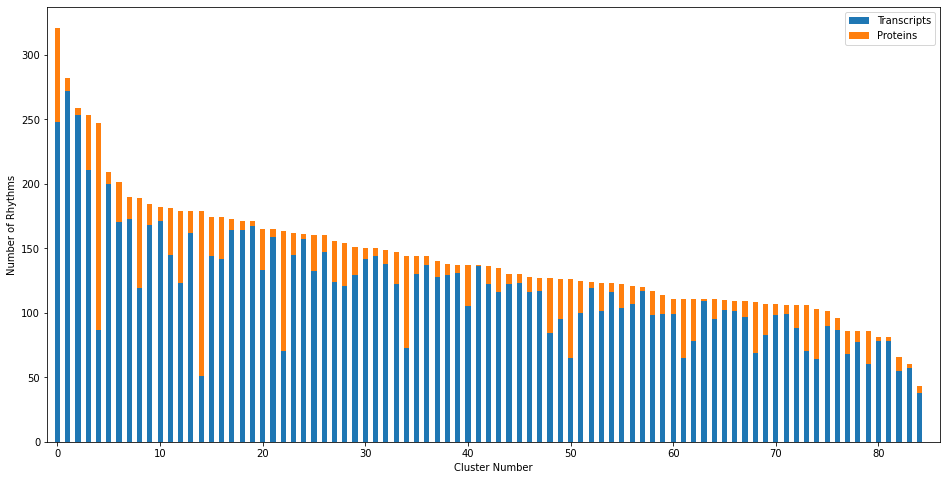

In [30]:
xval = np.arange(85)

width = 0.5

weight_counts = {
    "Transcripts": trs,
    "Proteins": prs
}

fig, ax = plt.subplots(figsize = (16,8))
bottom = np.zeros(85)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(xval, weight_count, width, label = boolean, bottom = bottom)
    bottom += weight_count
ax.legend(loc = 'upper right')
ax.set_xlim(-1,86)
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Number of Rhythms')
plt.show()

In [22]:
for i in range()

84

In [255]:
pers = []
for j in np.unique(ground_sig[5]):
        
        
    idxs = np.where(ground_sig[5] == j)[0]
        

        
    pers.append(np.mean(df_c.iloc[idxs,7]))
        


In [243]:
cl_df = pd.DataFrame([ids,np.array(ground_surprise[5])])
cl_df = cl_df.T
cl_df.to_csv('Surprise_labels.csv')

In [ ]:
sig_lab = pd.read_csv('Grouped_Significance.csv')
labels = np.array(sig_lab.iloc[:,0].values)
sig_ids = []
for i in range(np.unique(labels).shape[0]):
    temp_idxs = np.where(labels == i)[0]
    temp_ids  = ids[temp_idxs]
    temp_df   = pd.DataFrame(temp_ids)
    sig_ids.append(temp_df)



In [260]:
np.mean(df_c.iloc[np.where(np.array(ground_surprise[4])==5)[0],7])

27.171632066196604

In [261]:
clust_num = []
cl_size   = []
clust_per = []
clust_sd  = []
mwu = []
pers = df_c.iloc[:,]

for i in tqdm(np.where(np.logical_and(np.array(pers)<28, np.array(pers)>20))[0]):
    
    idxs = np.where(ground_surprise == i)[0]
    stdev = np.std(df_c.iloc[idxs,7])
    mean = np.mean(df_c.iloc[idxs,7])
    clust_avg = np.mean(x[idxs,:], axis = 0)
    corr_clu = []
    corr_avg = []
    for j in idxs:
        corr_clu.append(pearsonr(x[j,:], clust_avg))
        corr_avg.append(pearsonr(x[j,:], avg))
    
    if (mean-stdev) > 20 and mean+stdev < 28:
        clust_num.append(i)
        clust_per.append(mean)
        clust_sd.append(stdev)
        cl_size.append(idxs.shape[0])
        mwu.append(mannwhitneyu(x=corr_clu, y=corr_avg)[1][1])
        
unw_data = pd.DataFrame([clust_num, cl_size,clust_per, clust_sd, mwu])
unw_data.T

 38%|███████████████████████████████▏                                                  | 16/42 [00:00<00:00, 76.63it/s]C:\Users\chube\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\chube\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 132.58it/s]


,0,1,2,3,4
0,17.0,173.0,24.341909,1.949010,1.071997e-56
1,24.0,161.0,21.852614,1.309746,9.463391e-54
2,26.0,160.0,25.026928,0.956654,4.954428e-53
3,42.0,136.0,24.122733,1.376914,4.119392e-46
4,53.0,123.0,26.446651,1.168155,1.072159e-41
5,66.0,109.0,21.151631,0.753585,4.298530e-36
6,74.0,103.0,26.256849,1.419319,2.660152e-35
7,77.0,86.0,22.745509,0.943387,1.004835e-29
8,78.0,86.0,23.256102,2.071003,6.417616e-08


In [233]:
np.mean(unw_data.T.iloc[:,3])

1.1825398683531896

In [223]:
unwT = unw_data.T
unw_data.T.columns = ['Cluster Label Number', 'Number of Analytes in Cluster', 'Average Cluster Period', 'Standard Deviation in Period', 'MW P-Val']
unwT.to_csv('unw.csv')

In [224]:
unwT

,0,1,2,3,4
0,8.0,189.0,21.521255,1.082121,1.902621e-63
1,10.0,182.0,25.097162,2.031290,3.695504e-61
2,17.0,173.0,24.341909,1.949010,1.071997e-56
3,24.0,161.0,21.852614,1.309746,9.463391e-54
4,26.0,160.0,25.026928,0.956654,4.954428e-53
5,38.0,138.0,22.658500,1.950684,9.123871e-47
6,41.0,137.0,25.695058,1.519745,6.231614e-10
7,42.0,136.0,24.122733,1.376914,4.119392e-46
8,44.0,130.0,24.440504,2.678058,1.735288e-36
9,53.0,123.0,26.446651,1.168155,1.072159e-41


In [220]:
np.mean(unw_data.T.iloc[:,2].values)

1.4949062871921686

In [171]:
unw_data = unw_data.T
unw_data.to_csv('unw_data.csv')

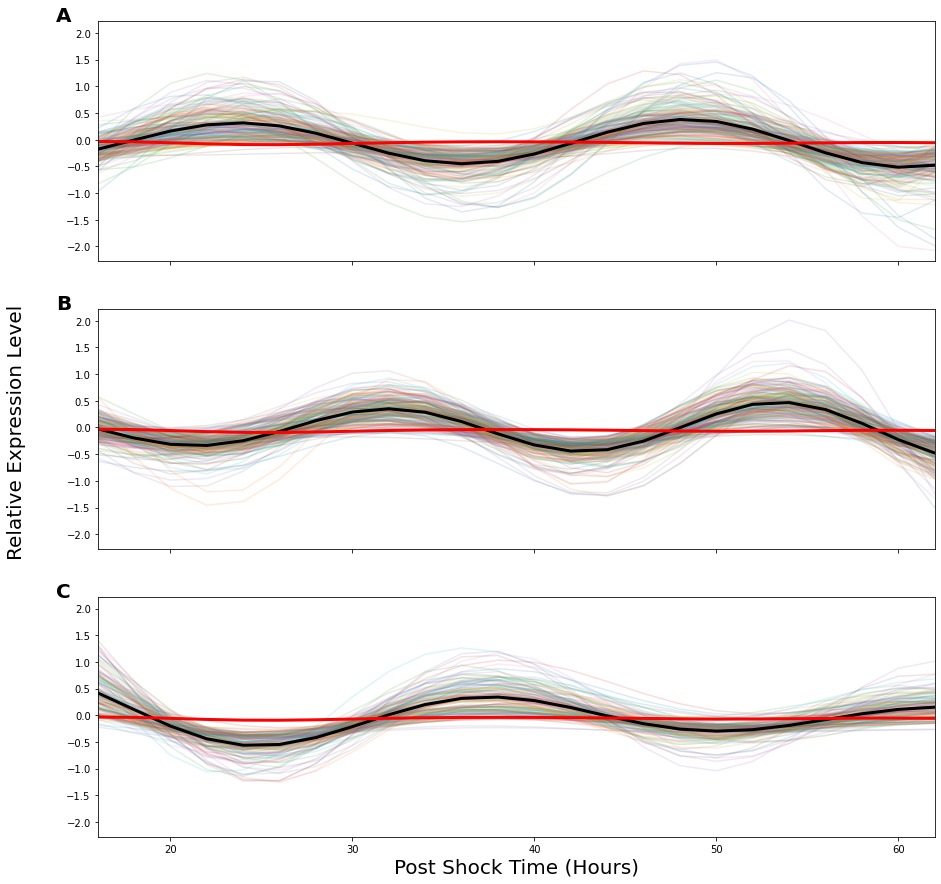

In [147]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, sharex = True, sharey = True)
fig.set_figheight(15)
fig.set_figwidth(15)


xval = (np.arange(24)*2)+16    
ax0_cluster = np.where(np.array(ground_surprise[5]) == 17)[0]
for i in range(ax0_cluster.shape[0]):
    data = df.iloc[ax0_cluster[i],:]
    ax[0].plot(xval, data, alpha = 0.15)
ax[0].plot(xval, np.mean(x[ax0_cluster,:], axis = 0), color = 'black', linewidth = 3)
ax[0].plot(xval, avg, color = 'red', linewidth = 3)
ax[0].set_xlim((16,62))
ax[0].text(-0.05, 1, 'A', transform=ax[0].transAxes, 
            size=20, weight='bold')

ax1_cluster = np.where(np.array(ground_surprise[5]) == 8)[0]
for i in range(ax1_cluster.shape[0]):
    data = df.iloc[ax1_cluster[i],:]
    ax[1].plot(xval, data, alpha = 0.15)
ax[1].plot(xval, np.mean(x[ax1_cluster,:], axis = 0), color = 'black', linewidth = 3)
ax[1].plot(xval, avg, color = 'red', linewidth = 3)
ax[1].set_xlim(16,62)
fig.text(0.05, 0.5, 'Relative Expression Level', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 20)
ax[1].text(-0.05, 1, 'B', transform=ax[1].transAxes, 
            size=20, weight='bold')
ax2_cluster = np.where(np.array(ground_surprise[5]) == 41)[0]
for i in range(ax2_cluster.shape[0]):
    data = df.iloc[ax2_cluster[i],:]
    ax[2].plot(xval, data, alpha = 0.15)
ax[2].plot(xval, np.mean(x[ax2_cluster,:], axis = 0), color = 'black', linewidth = 3)
ax[2].plot(xval, avg, color = 'red', linewidth = 3)
ax[2].set_xlim(16,62)
ax[2].text(-0.05, 1, 'C', transform=ax[2].transAxes, 
            size=20, weight='bold')
plt.xlabel('Post Shock Time (Hours)', fontsize = 20)


fig.savefig('Fig5.png', bbox_inches = 'tight')

In [2]:
def GaussianNoiseGenerator(noise, data, r):
    if len(data.shape) == 1:
        n_rows = len(data)
        n_cols = 1
        NoiseLayer = np.empty((n_rows))
    else:
        n_rows, n_cols = data.shape
        NoiseLayer = np.empty((n_rows, n_cols))
    
    if noise == 0:
        return data
    
    for i in range(n_cols):
        np.random.seed(r*i)
        scale = noise*np.std(data[:,i])
        if len(NoiseLayer.shape) == 1:
            NoiseLayer = np.random.normal(loc = 0, scale = scale, size = n_rows)
        else:
            NoiseLayer[:,i] = np.random.normal(loc = 0, scale = scale, size = n_rows)
        NoiseLayer[:,i] = shuffle(NoiseLayer[:,i], random_state = r*i)
            
    NoisyData = np.copy(data) + NoiseLayer
        
    return NoisyData

In [244]:
x = np.array(df)
ari_leid2=[]
ari_surp2=[]
ari_rber2=[]
ari_sign2=[]
num_iter = 50
noise_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for i in range(len(G_list)):
    print('Starting graph '+str(i+1))
    m1 = np.zeros((10,))
    m2 = np.zeros((10,))
    m3 = np.zeros((10,))
    m4 = np.zeros((10,)) 
    for j in range(len(noise_levels)):
        n_ = noise_levels[j]
        temp = np.zeros((50,))
        temp2 = np.zeros((50,))
        temp3 = np.zeros((50,))
        temp4 = np.zeros((50,))
        for k in tqdm(range(num_iter)):
            N = GaussianNoiseGenerator(noise = n_, data = x, r = k)
            NC = np.array(pd.DataFrame(N).T.corr())
            temp_N = []
            
            if i == 0:
                N1 = np.copy(NC)
                N1[N1 < 0.95] = 0
                np.fill_diagonal(N1, 0)
                N1[N1 >= 0.95] = 1
                N_1 = nx.from_numpy_array(N1)
                temp_N = ig.Graph.from_networkx(N_1)
                
            elif i == 1:
                N2 = np.copy(NC)
                N2[N2 < 0.99] = 0
                np.fill_diagonal(N2, 0)
                N2[N2 >= 0.99] = 1
                N_2 = nx.from_numpy_array(N2)
                temp_N = ig.Graph.from_networkx(N_2)
            
            elif i == 2:
                N3 = np.copy(NC)
                N3[N3 < 0.90] = 0
                np.fill_diagonal(N3, 0)
                N3[N3 >= 0.90] = 1
                N_3 = nx.from_numpy_array(N3)
                temp_N = ig.Graph.from_networkx(N_3)
                
            elif i == 3:
                N4 = kneighbors_graph(N, n_neighbors = 20, metric = 'correlation', mode = 'connectivity').toarray()
                N_4 = nx.from_numpy_array(N4)
                temp_N = ig.Graph.from_networkx(N_4)
            
            elif i == 4:
                N5 = kneighbors_graph(N, n_neighbors = 40, metric = 'correlation', mode = 'connectivity').toarray()
                N_5 = nx.from_numpy_array(N5)
                temp_N = ig.Graph.from_networkx(N_5)
            
            elif i == 5:
                N6 = kneighbors_graph(N, n_neighbors = 80, metric = 'correlation', mode = 'connectivity').toarray()
                N_6 = nx.from_numpy_array(N6)
                temp_N = ig.Graph.from_networkx(N_6)
            
            elif i == 6:
                
                N7 = kneighbors_graph(N, n_neighbors = 100, metric = 'correlation', mode = 'connectivity').toarray()
                N_7 = nx.from_numpy_array(N7)
                temp_N = ig.Graph.from_networkx(N_7)
                
            leid = leidenalg.find_partition(temp_N, leidenalg.ModularityVertexPartition, seed = 1).membership
            surp = leidenalg.find_partition(temp_N, leidenalg.SurpriseVertexPartition, seed = 1).membership
            rber = leidenalg.find_partition(temp_N, leidenalg.RBERVertexPartition, seed = 1).membership
            sign = leidenalg.find_partition(temp_N, leidenalg.SignificanceVertexPartition, seed = 1).membership
                
            temp[k] = adjusted_mutual_info_score(ground_leiden[i], leid)
            temp2[k] = adjusted_mutual_info_score(ground_surprise[i], surp)
            temp3[k] = adjusted_mutual_info_score(ground_rber[i], rber)
            temp4[k] = adjusted_mutual_info_score(ground_sig[i], sign)
            
        m1[j] = np.mean(temp)
        m2[j] = np.mean(temp2)
        m3[j] = np.mean(temp3)
        m4[j] = np.mean(temp4) 
        
    ari_leid2.append(m1)
    ari_surp2.append(m2)
    ari_rber2.append(m3)
    ari_sign2.append(m4)
    

Starting graph 1


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Starting graph 2


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Starting graph 3


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Starting graph 4


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Starting graph 5


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Starting graph 6


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Starting graph 7


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [30:49<00:00, 37.00s/it]


In [ ]:
low_robust = pd.DataFrame([df_L[0], df_R[0], df_S[0], df_Si[0]])
low_robust = low_robust.T
low_robust.columns = ['Leiden', 'RB Potts', 'Surprise', 'Significance']
low_robust.index = ['0.95 CT', '0.99 CT', '0.90 CT', '20 NN', '40 NN', '80 NN', '100 NN']

high_robust = pd.DataFrame([df_L2[0], df_R2[0], df_S2[0], df_Si2[0]])
high_robust = high_robust.T
high_robust.columns = ['Leiden', 'RB Potts', 'Surprise', 'Significance']
high_robust.index = ['0.95 CT', '0.99 CT', '0.90 CT', '20 NN', '40 NN', '80 NN', '100 NN']

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(8)
sns.heatmap(low_robust, annot = True, cmap = "crest", ax = ax1)
ax1.text(-0.05, 1, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
sns.heatmap(high_robust, annot = True, cmap = "crest", ax = ax2)
ax2.text(-0.05, 1, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.xlabel('Community Detection Algorithm', fontsize = 20)
fig.text(0, 0.5, 'Adjacency Matrix', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 20)
fig.savefig('Fig4.png', bbox_inches = 'tight')
sns.heatmap(low_robust, annot = True, cmap = "crest")

In [9]:
df_L = pd.DataFrame(ari_leid)
df_L.to_csv('ami_leid2.csv')
df_S = pd.DataFrame(ari_surp)
df_S.to_csv('ami_surp2.csv')
df_R = pd.DataFrame(ari_rber)
df_R.to_csv('ami_rber2.csv')
df_Si = pd.DataFrame(ari_sign)
df_Si.to_csv('ami_sign2.csv')

In [ ]:
low_robust = pd.DataFrame([df_L[0], df_R[0], df_S[0], df_Si[0]])
low_robust = low_robust.T
low_robust.columns = ['Leiden', 'RB Potts', 'Surprise', 'Significance']
low_robust.index = ['0.95 CT', '0.99 CT', '0.90 CT', '20 NN', '40 NN', '80 NN', '100 NN']

high_robust = pd.DataFrame([df_L2[0], df_R2[0], df_S2[0], df_Si2[0]])
high_robust = high_robust.T
high_robust.columns = ['Leiden', 'RB Potts', 'Surprise', 'Significance']
high_robust.index = ['0.95 CT', '0.99 CT', '0.90 CT', '20 NN', '40 NN', '80 NN', '100 NN']

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(8)
sns.heatmap(low_robust, annot = True, cmap = "crest", ax = ax1)
ax1.text(-0.05, 1, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
sns.heatmap(high_robust, annot = True, cmap = "crest", ax = ax2)
ax2.text(-0.05, 1, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.xlabel('Community Detection Algorithm', fontsize = 20)
fig.text(0, 0.5, 'Adjacency Matrix', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 20)
fig.savefig('Fig4.png', bbox_inches = 'tight')
sns.heatmap(low_robust, annot = True, cmap = "crest")

In [245]:
df_L2 = pd.DataFrame(ari_leid2)

df_S2 = pd.DataFrame(ari_surp2)

df_R2 = pd.DataFrame(ari_rber2)

df_Si2 = pd.DataFrame(ari_sign2)


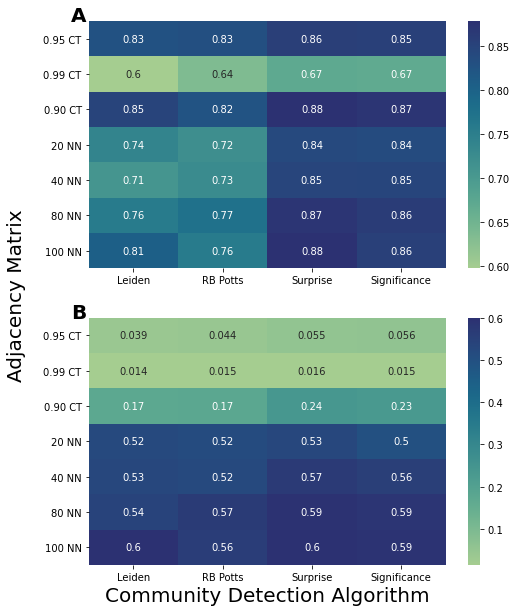

In [247]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(8)
sns.heatmap(low_robust, annot = True, cmap = "crest", ax = ax1)
ax1.text(-0.05, 1, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
sns.heatmap(high_robust, annot = True, cmap = "crest", ax = ax2)
ax2.text(-0.05, 1, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.xlabel('Community Detection Algorithm', fontsize = 20)
fig.text(0, 0.5, 'Adjacency Matrix', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 20)
fig.savefig('Fig4.png', bbox_inches = 'tight')

In [131]:
df_L.columns = noise_levels
df_L.index = ['0.95 Td', '0.99 Td', '0.9 Td', '20 NN', '40 NN', '80 NN', '100 NN']

In [132]:
df_S.columns = noise_levels
df_S.index = ['0.95 Td', '0.99 Td', '0.9 Td', '20 NN', '40 NN', '80 NN', '100 NN']

In [133]:
df_R.columns = noise_levels
df_R.index =['0.95 Td', '0.99 Td', '0.9 Td', '20 NN', '40 NN', '80 NN', '100 NN']

In [134]:
df_Si.columns = noise_levels
df_Si.index = ['0.95 Td', '0.99 Td', '0.9 Td', '20 NN', '40 NN', '80 NN', '100 NN']